In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import time
from datetime import datetime
from google.cloud.logging import DESCENDING, Client
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.family'] = 'monospace'

In [2]:
# fixTime = "2023-04-13T01:00:00.000000Z"
client = Client(project='ultra-sound-relay')

/usr/local/lib/python3.8/site-packages/google/auth/_default.py:78: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [15]:
# construct query
now = pd.Timestamp.utcnow()
prev = now - pd.Timedelta('24h')
logFilter = 'jsonPayload.method="getPayload" AND "execution payload delivered" ' + \
        'AND timestamp>=' + '\"' + (prev).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\" ' + \
        'AND timestamp<=' + '\"' + (now).strftime('%Y-%m-%dT%H:%M:%S.%fZ') + '\"'

# read results into a df
payloads = []
for e in client.list_entries(filter_=logFilter):
    payloads.append(e.to_api_repr()['jsonPayload'])
payloads = pd.DataFrame(payloads)
payloads = payloads.astype({'slot': 'int32'})

payloads.head()

,timestampRequestStart,blockNumber,timestampAfterDecode,method,timestampAfterAlreadyDelivered,proposerPubkey,slotStartSec,slot,mevBoostV,timestampAfterSignatureVerify,...,version,headSlot,timestampAfterPublishing,msIntoSlot,idArg,service,level,msg,numTx,ua
0,1.681421e+12,17041034.0,1.681421e+12,getPayload,1.681421e+12,0x98ffffdbab43394475b9379723e260fa66ab76fb90a4...,1.681421e+09,6216447,v1.5.0,1.681421e+12,...,,6216446.0,1.681421e+12,2373.0,btcs,relay/api,info,execution payload delivered,142.0,mev-boost/v1.5.0 okhttp/4.10.0
1,1.681421e+12,17041037.0,1.681421e+12,getPayload,1.681421e+12,0xae6494560be1b5104c7d465b2d89e68e84a2ea6cb157...,1.681421e+09,6216450,v1.5.0,1.681421e+12,...,,6216449.0,1.681421e+12,3433.0,,relay/api,info,execution payload delivered,511.0,mev-boost/v1.5.0 okhttp/4.10.0
2,1.681421e+12,17041041.0,1.681421e+12,getPayload,1.681421e+12,0xa7af3a3b7a4fa89b231befbe7d9d12cb98bf36a32503...,1.681421e+09,6216455,v1.5.0,1.681421e+12,...,,6216454.0,1.681421e+12,940.0,,relay/api,info,execution payload delivered,107.0,mev-boost/v1.5.0
3,1.681421e+12,17041042.0,1.681421e+12,getPayload,1.681421e+12,0x89e6ece670e05611b63bf39f6a1d702ea903f5c47e10...,1.681421e+09,6216456,v1.5.0,1.681421e+12,...,,6216455.0,1.681421e+12,2684.0,,relay/api,info,execution payload delivered,191.0,mev-boost/v1.5.0 okhttp/4.10.0
4,1.681422e+12,17041044.0,1.681422e+12,getPayload,1.681422e+12,0xb66ebe0aad5e96aeaf25cd1e088aefa51a32d944b861...,1.681422e+09,6216458,v1.5.0,1.681422e+12,...,,6216457.0,1.681422e+12,1109.0,,relay/api,info,execution payload delivered,146.0,mev-boost/v1.5.0 Prysm/v4.0.2/75338dd83d943ed5...


In [17]:
payloads.keys()

Index(['timestampRequestStart', 'blockNumber', 'timestampAfterDecode',
       'method', 'timestampAfterAlreadyDelivered', 'proposerPubkey',
       'slotStartSec', 'slot', 'mevBoostV', 'timestampAfterSignatureVerify',
       'blockHash', 'timestampBeforePublishing', 'contentLength', 'version',
       'headSlot', 'timestampAfterPublishing', 'msIntoSlot', 'idArg',
       'service', 'level', 'msg', 'numTx', 'ua'],
      dtype='object')

In [18]:
len(payloads.slot), len(set(payloads.slot))

(2146, 2117)

In [19]:
payloads = payloads.sort_values('msIntoSlot', ascending=True).drop_duplicates('slot').sort_index()
len(payloads)

2117

In [20]:
payloads.msIntoSlot

0       2373.0
1       3433.0
2        940.0
3       2684.0
4       1109.0
         ...  
2141     835.0
2142     897.0
2143     828.0
2144    1374.0
2145    1853.0
Name: msIntoSlot, Length: 2117, dtype: float64

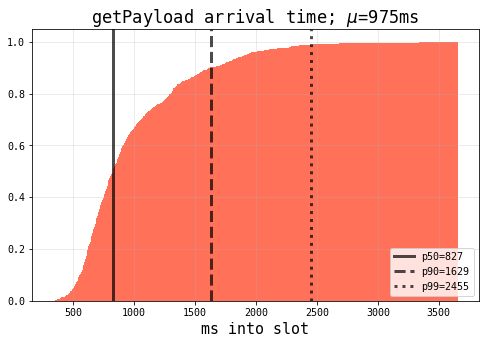

In [52]:
f, ax = plt.subplots(figsize=(8,5))
# ax2 = ax.twinx()

percs = [(int(i*100), np.quantile(payloads.msIntoSlot, i)) for i in [.50, .90, .99]]
linestyle = ['-', '--', ':']
for i, v in enumerate(percs):
    ax.axvline(v[1], label='p{}={:0.0f}'.format(v[0], v[1]), color='k', linestyle=linestyle[i], linewidth=3, alpha=0.7)

ax.hist(payloads.msIntoSlot, bins=500, density=True, alpha=0.9, cumulative=True, color='tomato')
# ax.hist(payloads.msIntoSlot, bins=500, density=True, alpha=0.9, color='tomato', label='pdf')
ax.set_xlabel('ms into slot', size=15)
ax.set_title('getPayload arrival time; $\mu$={:0.0f}ms'.format(payloads.msIntoSlot.mean()), size=17)
ax.legend(loc=4)
plt.show()